# SHAP Values 로 모델 해석하기

* Please read [Explain your model with the SHAP values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/goran/Desktop/winequality-red.csv') # ,sep=';')

In [3]:
df.shape

(1599, 12)

In [4]:
df.columns
df['quality'] = df['quality'].astype(int)

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:>

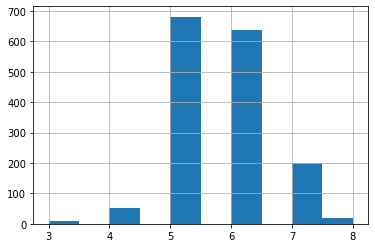

In [6]:
df['quality'].hist()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

Y = df['quality']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
X_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [211]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  
print(model.feature_importances_)

[0.02771784 0.14608857 0.0098873  0.03979135 0.03834853 0.02349039
 0.07114265 0.01940386 0.04327445 0.20548462 0.37537044]


# 전형적인 feature importance

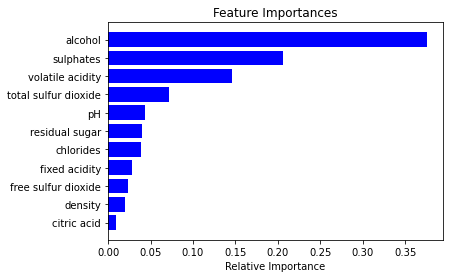

In [212]:
importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Tree model

In [15]:
import shap

In [214]:
# train 한 모델을 shape tree explainer 에 넣는다
# tree 에 최적화된 expliner 로, tree based model 에 대해서 매우 빠르다.
shap_explainer = shap.TreeExplainer(model)
# 어떤 모델로 설명할건지 explainer 에 넣는다. 
# 이떄 explainer 은 이미 trained 된 값을 넣는다.
shap_values = shap_explainer.shap_values(X_train)
# 어떤 X 에 대해서 shap values 를 형성할지 결정한다.
# 이떄 너무 크면 시간이 오래걸릴거야..! 
# 지금은 wine dataset 이 매우 작아서 그냥 X_train 을 다 넣었지만요, 나중에는 지~인짜 시간 오래걸리니까 random 으로 선택하시길!

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [215]:
shap_values
# 각 sample 에 대해 shapley value 가 형성되어있는것을 볼 수 있습니다. 
# 첫번째 sample 의 경우 fixed acidity(첫 col) 의 경우는 결과에 나름 긍정적인 영향을 미치고 있음을 알 수 있겟네요

array([[ 0.00198697, -0.01236634, -0.00149346, ..., -0.01394797,
        -0.01245832, -0.27732247],
       [-0.04005103,  0.154166  ,  0.00462336, ..., -0.01929661,
        -0.3303167 , -0.33255167],
       [-0.02387466,  0.22538997, -0.01196856, ...,  0.00387284,
         0.25647336,  0.02704326],
       ...,
       [ 0.00128333, -0.06902148,  0.00415396, ...,  0.00380529,
         0.11687488, -0.35173808],
       [-0.0145459 , -0.05240624, -0.00708143, ..., -0.02984688,
         0.11456521,  0.64145714],
       [ 0.00309235, -0.21837532,  0.00698086, ...,  0.02038698,
        -0.19891362, -0.24589498]])

Shapley value는 전체에 대한 설명(global explanations)으로 합쳐서 나타낼 수 있다. 모든 경우에 대해 SHAP을 실행하면 Shapley value의 행렬을 얻을 수 있다. 이 행렬은 한 개의 관측치인 행과 한 개의 특성인 열(column)을 가진다. 이 Shapley value의 행렬을 분석하면 전체 모델을 해석할 수 있게 된다.



## Feature improtance

SHAP feature importance의 원리는 간단하다. 절대값 Shapley value가 큰 특성이 가장 중요하며, global importance를 원하기 때문에 데이터 전체에서 특성 당 Shapley values의 절댓값 평균을 낸다.

$I_j=\sum_{i=1}^n{}|\phi_j^{(i)}|$

SHAP feature importance는 permutation feature importance의 대안이며, 두 가지 방법은 중요도 측정에서 가장 큰 차이점을 보인다. Permutation feature importance는 모델 성능의 감소에 기반을 두지만 SHAP은 특성 기여도의 크기에 기반을 둔다.

feature importance plot은 유용하지만 중요도에 아무런 정보를 포함하지 않아, 더 많은 정보를 주는 시각화를 보기위해서는 summary plot을 확인하면 된다.

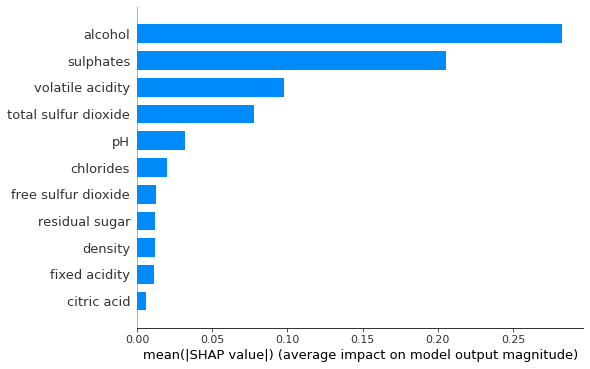

In [216]:
shap.summary_plot(shap_values, # 제일 처음에는 shap_values 를 형성한 객체를 넣어줍니다! 여기에는 각 sample 별로 shap 값들이 특성별로 저장이 되어있는 array 에요
                  X_train, # 두번쨰 값에는 어떤 data 로 위의 shap_values 를 계산했는지를 넣어줍니다. 이떄 dataframe 을 넣어주어야 col name 이 나와주는듯 해요
                  plot_type="bar" # plot_type 을 bar 로 지정해 주어야 , 위처럼 특성 중요도를 절댓값으로 합산해서 중요도를 정하게 됩니다.
                 ) 
# 이떄에 중요도란.. shapley value 들의 합산인것입니다. 즉 예측값에 얼마나 큰 '영향' 을 주엇냐이지, 이게 긍정인지 부정인지는 모르는 상태입니다..

## Feature summary

- summary plot 은 특성 중요도와 , 특성 효과를 결합한 것입니다.
- 특성의 맨 위는 위의 bar chart 에서 보시다 시피 중요도에 따라 정렬된 것이에요
- summary plot에서 각 점은 관측치들을 나타냅니다 
- 색은 특성의 값을 낮음에서 높음까지 나타냅니다. 즉 alcohol 에서의 빨간점은, 그 지점에서 값이 매우 크다는것이에요
- 가로는값은 각 관측치에서의 특성에 대한 Shapley value 를 나타내는것 입니다.
- 세로는 특성들을 나타냅니다.
- 우리가 한 관측치에 대해서 특성의 수만큼 shapley value 가 나온다고 했죠? 즉 데이터 1개만에 대해서 summary plot 을 보개되면 alcohol..... frees sulfur dioxide 에 각각 하나의 점이 찍힐거에요


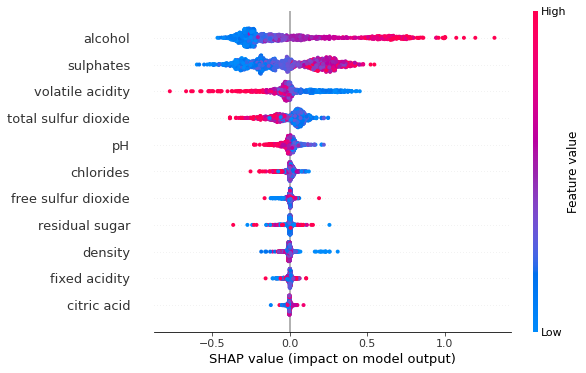

In [217]:
shap.summary_plot(shap_values,
                  X_train)

위의 정보를 보면 , 우리는 한가지 사실을 알 수 있습니다.
좋은 퀄러티의 와인은 다음과 같은 특징을 가져야해요
* High alcohol content 
* High sulphates 
* Low volatile acidity 
* Low total sulfuer dioxide 
* Low pH 
* Low chlorides
* Low citric acid
* Low density
* High fixed acidity content
* High free sulfur dioxide
* High residual sugar

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (the average number of rooms per house in an area) changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that the average number of rooms per house has less impact on home price for areas with a high RAD value.

## Feature dependence

SHAP feature dependence는 가장 단순한 global interpretation 시각화이다.

방법

1. 특성을 선택한다.
2. 각 관측치에 대해 특성 값을 x축에, 해당하는 Shapley value를 y축에 표시한다.

수학적으로 이 그래프는 다음의 점을 포함한다. $ \{(x_j^{(i)},\phi_j^{(i)})\}_{i=1}^n $

- i ~ n 은 sample 의 수를 의미하며 (우리는 X_train 을 모조리 썻으니까 X_train 의 수겠죠?)
- x_j 는 각 특성입니다.
- phi_j 는 j 특성에서의 shap 값 입니다.

- 함수는 자동으로 interacts 를 제일 많이 한 variable 을 골라줍니다.

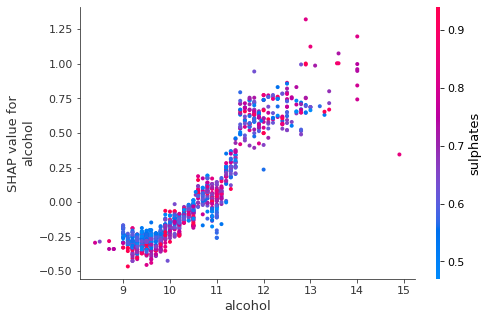

In [218]:
# we pass "Age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that 
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("alcohol", shap_values, X_train)
# 맨 앞은 계산하고픈 shap 값을 넣어줍니다. 이떄에 columns 의 names 를 써주면, index 를 알아서 찾아줍니다 ^^
#shap_values : 계산했던 shap 값을 넣어주어야 합니다.(# samples x # features).
#features : numpy.array or pandas.DataFrame Matrix of feature values (# samples x # features)

In [219]:
# 위 경우는 sulphates 의 경우가 alcohol 과 가장 상호작용이 많은 경우에서 plot 을 보여줍니다.
# 하지만 사람의 눈으로 보기엔 어떤 상호작용이 강하게 있었는지는 알기 어렵네요.. 

상호작용 효과는 개별 특성 효과에 대해 고려한 후에 각 효과를 결합한 특성 효과이다. 게임 이론의 Shapley 상호작용 지수는 다음과 같이 정의한다.

$ \phi_{i,j}=\sum_{S\subseteq\setminus\{i,j\}}\frac{|S|!(M-|S|-2)!}{2(M-1)!}\delta_{ij}(S) $

$ i\neq{}j $ 일 떄에

$ \delta_{ij}(S)=f_x(S\cup\{i,j\})-f_x(S\cup\{i\})-f_x(S\cup\{j\})+f_x(S) $ 

이 공식은 개별 효과를 고려한 후 순수 상호 작용 효과를 얻을 수 있도록 특성의 주효과를 뺀다. Shapley value 계산에서와 같이 가능한 모든 특성 연합(coalition) S에 대한 값을 평균낸다. 모든 특성에 대해 SHAP 상호 작용 값을 계산할 때, 관측치 당 하나의 행렬(M*M차원)을 얻는다. 여기서 M은 특성의 수를 나타낸다.

어떻게 상호 작용 지수를 사용할 수 있을까? 예를 들어, 가장 강한 상호작용이 있는 SHAP feature dependence 그래프에 자동으로 색상을 칠해줄 수 있다.

그게 바로 위의 결과인데, 사람이 해석하기에는 살짝 어려운 그래프가 나와서 여기서는 pass 하자.



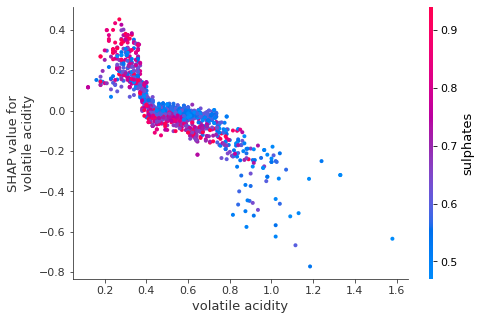

In [220]:
shap.dependence_plot("volatile acidity", shap_values, X_train)
# 이 경우에는

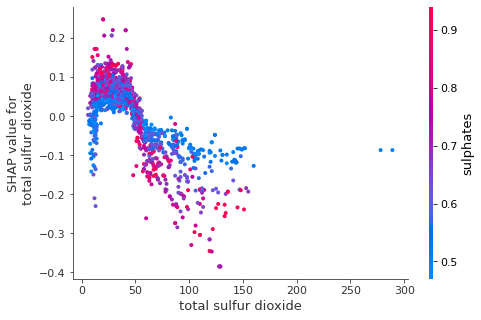

In [221]:
shap.dependence_plot("total sulfur dioxide", shap_values, X_train, show=False)
plt.show()
# 이 경우에는 낮은 값의 의 sulphates , 낮은값의 total sulfur 가 합쳐지면 어느정도 높은 shap 값이 나온다는것을 알 수 있다.

## Feature Interaction

상호작용 효과는 개별 특성 효과에 대해 고려한 후에 각 효과를 결합한 특성 효과이다. 게임 이론의 Shapley 상호작용 지수는 다음과 같이 정의한다.

$ \phi_{i,j}=\sum_{S\subseteq\setminus\{i,j\}}\frac{|S|!(M-|S|-2)!}{2(M-1)!}\delta_{ij}(S) $

$ i\neq{}j $ 일 떄에

$ \delta_{ij}(S)=f_x(S\cup\{i,j\})-f_x(S\cup\{i\})-f_x(S\cup\{j\})+f_x(S) $ 

이 공식은 개별 효과를 고려한 후 순수 상호 작용 효과를 얻을 수 있도록 특성의 주효과를 뺀다. Shapley value 계산에서와 같이 가능한 모든 특성 연합(coalition) S에 대한 값을 평균낸다. 모든 특성에 대해 SHAP 상호 작용 값을 계산할 때, 관측치 당 하나의 행렬(M*M차원)을 얻는다. 여기서 M은 특성의 수를 나타낸다.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


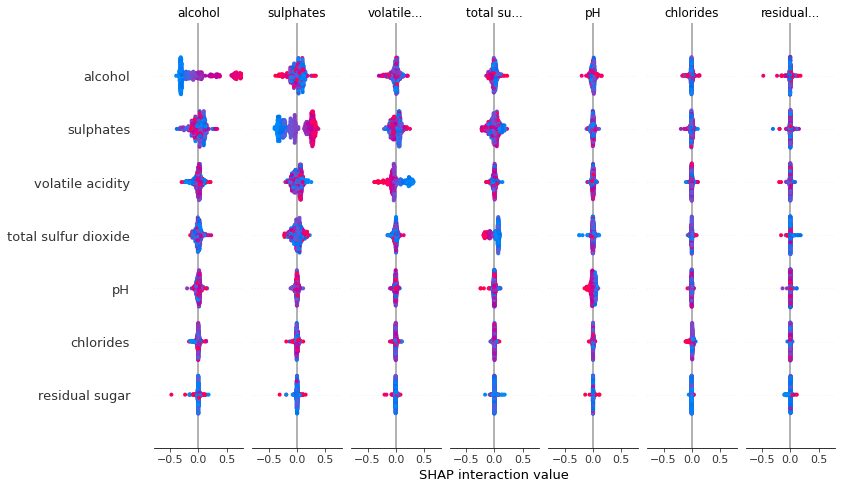

In [222]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker

shap_explainer = shap.TreeExplainer(model)

shap_values = shap_explainer.shap_values(X_train)

shap_interaction_values = shap_explainer.shap_interaction_values(X_train.iloc[:500,:]) # 500개까지만 봐요! 너무힘들어

shap.summary_plot(shap_interaction_values, X_train.iloc[:500,:]) 
# 2000 개의 데이터를 보면, 어떤것이 interaction 이 큰지 대충 감이 올겁니다.

In [223]:
shap_interaction_values.shape 
# 이걸 보면 1279 개의 데이터에 들은 하나하나마다 11 * 11 의 각 특성에 대한 interaction 을 계산해서 저장함을 알 수 있죠!
# 위의 경우는 interaction 이 크다고 생각되어지는 것을 상위로 보여줍니다..?

(500, 11, 11)

## Decision plot

Refer to the decision plot of the 20 test observations below. *Note: This plot isn't informative by itself; we use it only to illustrate the primary concepts.*
* The x-axis represents the model's output. In this case, the units are log odds.
* The plot is centered on the x-axis at `explainer.expected_value`. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.
* The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. *This is usually different than the importance ordering for the entire dataset.* In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
* Each observation's prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
* Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction.
* At the bottom of the plot, the observations converge at `explainer.expected_value`.

In [228]:
shap_values[1:3]

array([[-0.04005103,  0.154166  ,  0.00462336,  0.00433045,  0.0266009 ,
         0.00352185,  0.01694389,  0.00824068, -0.01929661, -0.3303167 ,
        -0.33255167],
       [-0.02387466,  0.22538997, -0.01196856, -0.01403788,  0.02120816,
        -0.05326441,  0.05593098, -0.00696192,  0.00387284,  0.25647336,
         0.02704326]])

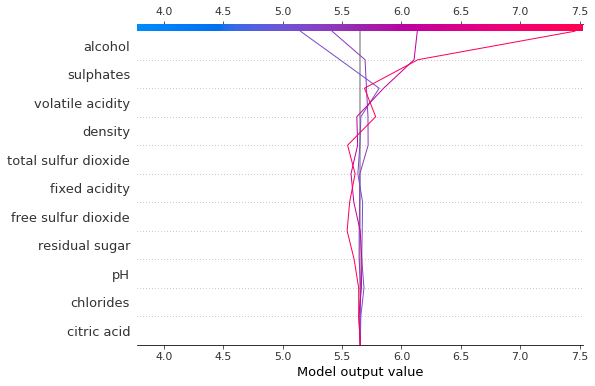

In [230]:
shap.decision_plot(shap_explainer.expected_value,
                   shap_values[:4], # 4개만 볼게요~ (더 볼려면 index 를 늘려)
                   X_train) # 여기에 들어간 X_train 은 그냥 feature value 를 뽑아내기 위한녀석에 불과하다.. ㅜㅜ

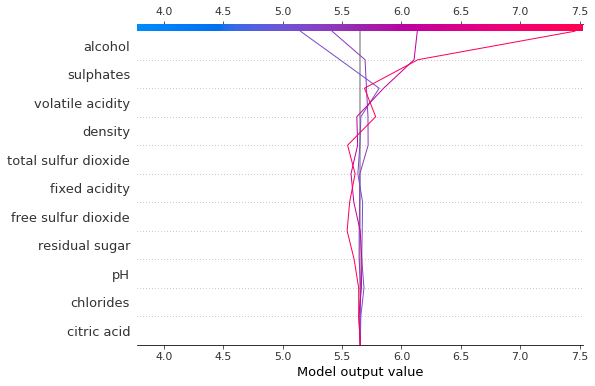

In [236]:
shap.decision_plot(shap_explainer.expected_value,
                   shap_values[:4], # 4개만 볼게요~ (더 볼려면 index 를 늘려)
                   X_train) # 여기에 들어간 X_train 은 그냥 feature value 를 뽑아내기 위한녀석에 불과하다.. ㅜㅜ

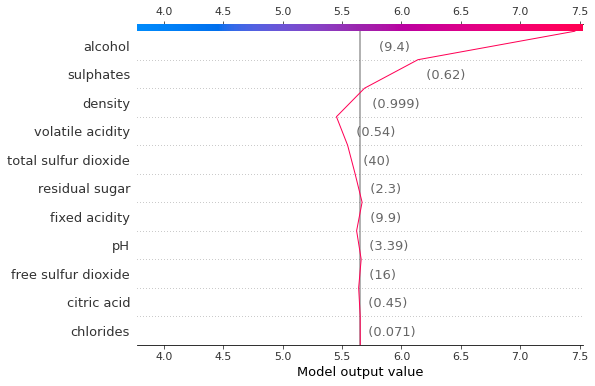

In [239]:
shap.decision_plot(shap_explainer.expected_value,
                   shap_values[3], # 1개만 볼게요 # 그러면 각 상태에서 어떤 선택을 해서 값이 나왔는지를 알게된다.
                   X_train,
                  feature_display_range=slice(None, -31, -1)) # 31개까지 보여달란거
# slice(None, None, -1) 를 하면 최대한 다 보여달라는 것이다. 이럴 경우 겁나게 커지는건 인지상정!

## 개별관측

In [162]:
# 관측의 단계는 fitting 이 끝난 후, test 데이터에 시행하는게 바람직 할 것이다! (그래야 모델의 완전한 효과를 볼 수 있을것이므로)

In [163]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)
random_picks = np.arange(1,330,50)
Sample = X_output.iloc[random_picks]
Sample

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,predict
1032,8.1,0.820,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,4.50
34,5.2,0.320,0.25,1.8,0.103,13.0,50.0,0.99570,3.38,0.55,9.2,5.35
1508,7.1,0.270,0.60,2.1,0.074,17.0,25.0,0.99814,3.38,0.72,10.6,6.26
1479,8.2,0.280,0.60,3.0,0.104,10.0,22.0,0.99828,3.39,0.68,10.6,5.93
866,6.8,0.490,0.22,2.3,0.071,13.0,24.0,0.99438,3.41,0.83,11.3,6.33
1519,6.6,0.700,0.08,2.6,0.106,14.0,27.0,0.99665,3.44,0.58,10.2,5.47
1193,6.4,0.885,0.00,2.3,0.166,6.0,12.0,0.99551,3.56,0.51,10.8,4.51


In [164]:
shap.initjs()

In [165]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(Sample) # 지금은 Sample 에 대해서 해석하고싶어~

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### waterfall 시각화

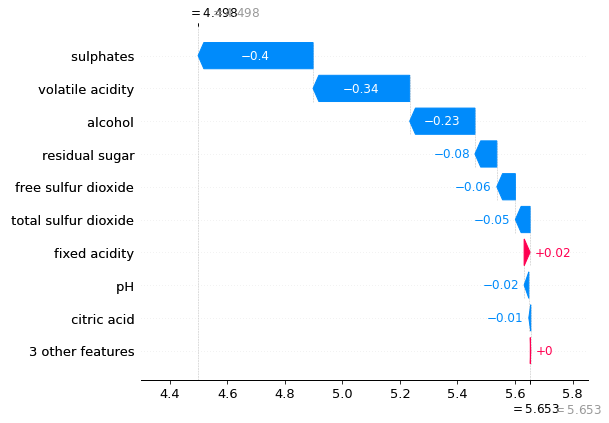

In [185]:
shap.waterfall_plot(shap_explainer.expected_value[0] # explainer 가 예측한 값!
                    ,shap_values[0], # shap 값.
                    Sample.iloc[0,:], # 원래 여따가 pd.dataframe 넣으면 feature name 쓸 필요없는데, waterfall 시각화가 쓰레기라 안먹히나봐요.
                    feature_names=X_features) # 그래서 여따가 x_feature 의 이름을 써주어야했습니다  ㅠㅠ
# 예측의 기여를 순서대로 볼 수 있어요.
# 거의 다 뭐 안좋은거 투성이네요.

### force_plot 시각화

In [189]:
Sample.iloc[[0]]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,predict
1032,8.1,0.82,0.0,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,4.5


In [176]:
shap.force_plot(shap_explainer.expected_value,  # expected_value 는 explainer (여기선 tree model) 이 fitting 할 때의 train set 에서 예측한 target 의 평균입니다.
                shap_values[0], # 첫번쨰 sample 에 대한 shap 값!
                Sample.iloc[[0]]) # 여기서 dataframe 이 들어가서 굳이 feature name 써줄필요가 없어요! 좋아라
# 결과해석은 아래를 보면, 평균값이 baseline 이고, 여기서 어떤것들에 의해 값이 적어져서 예측치(위의 굵은 글씨) 가 나왔는지 알려줍니다.
# 해당하는 값들은 아래 파란 글씨로 써져있습니다 알콜에 대해서 위의 df 와 값이 같죠?

In [190]:
# 이렇게 정의해서 할 수 도 있어요~
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(Sample)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], Sample.iloc[[j]])
    return(p)

shap_plot(0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


* Output value: is the prediction for that observation
* Base value: The [original paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). So the mean prediction of Y_test is 5.62.
* Features: The above explanation shows features that contributes to push the final prediction away from the base value.
* Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue. 
* Alcohol: has positive impact on the quality rating. The alcohol of this wine is 11.8 which is higher than the average value 10.41. So it pushes the prediction to the right.
* pH: has a negative impact on the quality rating. A lower than the average pH (=3.26 <3.30) drives the prediction to the right.
* Sulphates: is positively related to the quality rating. A lower than the average Sulphates (= 0.64 < 0.65) pushes the prediction to the left.

In [191]:
shap_plot(1)

In [192]:
shap_plot(2)

In [193]:
shap_plot(3)

In [194]:
shap_plot(4)

## 총 관측

In [195]:
shap.force_plot(shap_explainer.expected_value, shap_values, X_test)
# X test 에 대해서 모조리 본것입니다. 
# 축의 값들은 조절이 가능합니다. 
# default 는 outputvalur 가 세로 입니다. 
# 가로는 유사도에 의해 배열한 것으로 크게 의미는 없는듯..??

# Deep learning model

In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

In [71]:
model2 = keras.models.Sequential()
model2 = Sequential([
    Dense(128, activation='relu',input_shape=X_train.shape[1:]),
    Dense(32 , activation = "relu"),
    Dense(1)
])

model2.compile(loss="mse",  # 평가기준이 mape 이니까 이걸로 하자.
              optimizer=keras.optimizers.Adam())
history2 = model2.fit(X_train, Y_train, 
                        epochs=10)
evaluation2 = model2.evaluate(X_test, Y_test) 

Epoch 1/10
40/40 [==============================] - 0s 1ms/step - loss: 19.2908
Epoch 2/10
40/40 [==============================] - 0s 1ms/step - loss: 0.8138
Epoch 3/10
40/40 [==============================] - 0s 1ms/step - loss: 0.6167
Epoch 4/10
40/40 [==============================] - 0s 923us/step - loss: 0.5678
Epoch 5/10
40/40 [==============================] - 0s 1ms/step - loss: 0.5306
Epoch 6/10
40/40 [==============================] - 0s 997us/step - loss: 0.5200
Epoch 7/10
40/40 [==============================] - 0s 2ms/step - loss: 0.5121
Epoch 8/10
40/40 [==============================] - 0s 2ms/step - loss: 0.5036
Epoch 9/10
40/40 [==============================] - 0s 2ms/step - loss: 0.5083
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.4712


In [142]:
background_pd = X_train.iloc[:1000,]
background=np.array(X_train.iloc[:1000,])
# 딥러닝 모델에서 주의해야할점 
# 1. 위와는 다르게 np.array 형태로 집어넣어야 합니다...

In [91]:
# 2. 이렇게 Deepexplainer 로 정의해야 합니다.
shap_explainer = shap.DeepExplainer(model2,background)
shap_values = shap_explainer.shap_values(background)


In [92]:
# 3. shap_values 가 list 가 바깥에 하나 더 있는형태로 나와요! 왜이래 진짜
shap_values

[array([[ 1.29116352e-01,  8.00752484e-05,  2.01887310e-02, ...,
          2.05463387e-02, -6.52595784e-03, -3.54041270e-01],
        [ 1.96701510e-01, -1.04986107e-02,  2.01763039e-02, ...,
         -4.57123552e-02, -2.14593875e-02, -2.89627805e-01],
        [ 1.53128371e-01,  1.37329447e-02,  3.19717629e-02, ...,
         -1.21329055e-02,  2.34652095e-02,  5.89890815e-02],
        ...,
        [-2.12199312e-01, -6.44262992e-03, -9.35259241e-03, ...,
          2.01902291e-02,  2.18793994e-02, -1.44623797e-01],
        [ 6.37098465e-02,  3.14567518e-03, -2.01726441e-02, ...,
          4.85441192e-04, -2.21835451e-02, -3.19903015e-01],
        [ 5.15967800e-02, -8.76230402e-03, -1.42663095e-02, ...,
          7.65332195e-03, -2.76094512e-03,  2.85191307e-02]])]

Shapley value는 전체에 대한 설명(global explanations)으로 합쳐서 나타낼 수 있다. 모든 경우에 대해 SHAP을 실행하면 Shapley value의 행렬을 얻을 수 있다. 이 행렬은 한 개의 관측치인 행과 한 개의 특성인 열(column)을 가진다. 이 Shapley value의 행렬을 분석하면 전체 모델을 해석할 수 있게 된다.



## Feature improtance

SHAP feature importance의 원리는 간단하다. 절대값 Shapley value가 큰 특성이 가장 중요하며, global importance를 원하기 때문에 데이터 전체에서 특성 당 Shapley values의 절댓값 평균을 낸다.

$I_j=\sum_{i=1}^n{}|\phi_j^{(i)}|$

SHAP feature importance는 permutation feature importance의 대안이며, 두 가지 방법은 중요도 측정에서 가장 큰 차이점을 보인다. Permutation feature importance는 모델 성능의 감소에 기반을 두지만 SHAP은 특성 기여도의 크기에 기반을 둔다.

feature importance plot은 유용하지만 중요도에 아무런 정보를 포함하지 않아, 더 많은 정보를 주는 시각화를 보기위해서는 summary plot을 확인하면 된다.

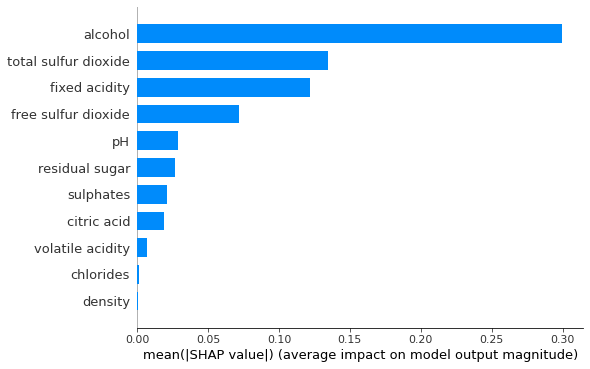

In [143]:
shap.summary_plot(shap_values[0], # 그래서 여기에 [0] 을 위와 다르게 붙여줘야 된답니다.
                   X_train.iloc[:1000,],  # 3. 그냥 특성용에 불과한 데이터인데 앞의 값과 크기를 일치시켜주어야해요.. ㅠ
                  plot_type="bar" # plot_type 을 bar 로 지정해 주어야 , 위처럼 특성 중요도를 절댓값으로 합산해서 중요도를 정하게 됩니다.
                 ) 
# 이떄에 중요도란.. shapley value 들의 합산인것입니다. 즉 예측값에 얼마나 큰 '영향' 을 주엇냐이지, 이게 긍정인지 부정인지는 모르는 상태입니다..

## Feature summary

- summary plot 은 특성 중요도와 , 특성 효과를 결합한 것입니다.
- 특성의 맨 위는 위의 bar chart 에서 보시다 시피 중요도에 따라 정렬된 것이에요
- summary plot에서 각 점은 관측치들을 나타냅니다 
- 색은 특성의 값을 낮음에서 높음까지 나타냅니다. 즉 alcohol 에서의 빨간점은, 그 지점에서 값이 매우 크다는것이에요
- 가로는값은 각 관측치에서의 특성에 대한 Shapley value 를 나타내는것 입니다.
- 세로는 특성들을 나타냅니다.
- 우리가 한 관측치에 대해서 특성의 수만큼 shapley value 가 나온다고 했죠? 즉 데이터 1개만에 대해서 summary plot 을 보개되면 alcohol..... frees sulfur dioxide 에 각각 하나의 점이 찍힐거에요


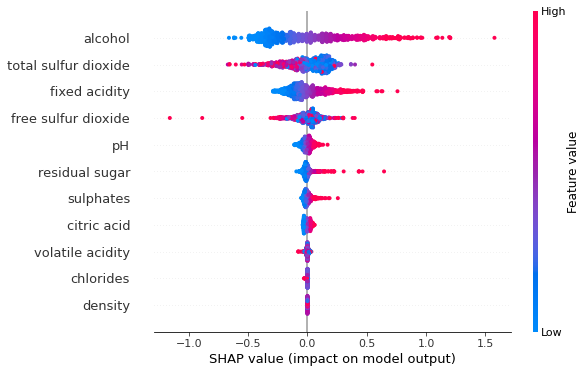

In [144]:
shap.summary_plot(shap_values[0],
                  X_train.iloc[:1000,]) # 귀찮치만 X_train 의 값을 맞춰줘야 되는 모양입니다...

위의 정보를 보면 , 우리는 한가지 사실을 알 수 있습니다.
좋은 퀄러티의 와인은 다음과 같은 특징을 가져야해요
* High alcohol content 
* High sulphates 
* Low volatile acidity 
* Low total sulfuer dioxide 
* Low pH 
* Low chlorides
* Low citric acid
* Low density
* High fixed acidity content
* High free sulfur dioxide
* High residual sugar

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as RM (the average number of rooms per house in an area) changes. Vertical dispersion at a single value of RM represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways) highlights that the average number of rooms per house has less impact on home price for areas with a high RAD value.

## Feature dependence

SHAP feature dependence는 가장 단순한 global interpretation 시각화이다.

방법

1. 특성을 선택한다.
2. 각 관측치에 대해 특성 값을 x축에, 해당하는 Shapley value를 y축에 표시한다.

수학적으로 이 그래프는 다음의 점을 포함한다. $ \{(x_j^{(i)},\phi_j^{(i)})\}_{i=1}^n $

- i ~ n 은 sample 의 수를 의미하며 (우리는 X_train 을 모조리 썻으니까 X_train 의 수겠죠?)
- x_j 는 각 특성입니다.
- phi_j 는 j 특성에서의 shap 값 입니다.

- 함수는 자동으로 interacts 를 제일 많이 한 variable 을 골라줍니다.

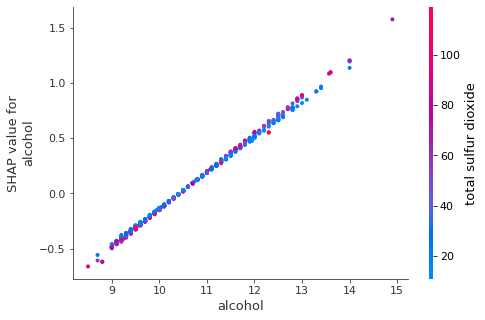

In [146]:
shap.dependence_plot('alcohol', shap_values[0], X_train.iloc[:1000,])
# 즈응말 귀찮네요. 

In [147]:
# 위 경우는 sulphates 의 경우가 alcohol 과 가장 상호작용이 많은 경우에서 plot 을 보여줍니다.
# 하지만 사람의 눈으로 보기엔 어떤 상호작용이 강하게 있었는지는 알기 어렵네요.. 

상호작용 효과는 개별 특성 효과에 대해 고려한 후에 각 효과를 결합한 특성 효과이다. 게임 이론의 Shapley 상호작용 지수는 다음과 같이 정의한다.

$ \phi_{i,j}=\sum_{S\subseteq\setminus\{i,j\}}\frac{|S|!(M-|S|-2)!}{2(M-1)!}\delta_{ij}(S) $

$ i\neq{}j $ 일 떄에

$ \delta_{ij}(S)=f_x(S\cup\{i,j\})-f_x(S\cup\{i\})-f_x(S\cup\{j\})+f_x(S) $ 

이 공식은 개별 효과를 고려한 후 순수 상호 작용 효과를 얻을 수 있도록 특성의 주효과를 뺀다. Shapley value 계산에서와 같이 가능한 모든 특성 연합(coalition) S에 대한 값을 평균낸다. 모든 특성에 대해 SHAP 상호 작용 값을 계산할 때, 관측치 당 하나의 행렬(M*M차원)을 얻는다. 여기서 M은 특성의 수를 나타낸다.

어떻게 상호 작용 지수를 사용할 수 있을까? 예를 들어, 가장 강한 상호작용이 있는 SHAP feature dependence 그래프에 자동으로 색상을 칠해줄 수 있다.

그게 바로 위의 결과인데, 사람이 해석하기에는 살짝 어려운 그래프가 나와서 여기서는 pass 하자.



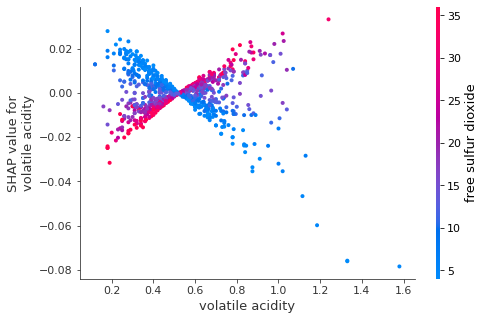

In [148]:
shap.dependence_plot("volatile acidity", shap_values[0],  X_train.iloc[:1000,])
# 이 경우에는

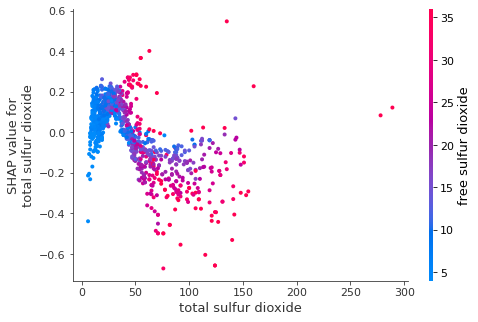

In [149]:
shap.dependence_plot("total sulfur dioxide", shap_values[0], X_train.iloc[:1000,], show=False)
plt.show()
# 이 경우에는 낮은 값의 의 sulphates , 낮은값의 total sulfur 가 합쳐지면 어느정도 높은 shap 값이 나온다는것을 알 수 있다.

## Feature Interaction

상호작용 효과는 개별 특성 효과에 대해 고려한 후에 각 효과를 결합한 특성 효과이다. 게임 이론의 Shapley 상호작용 지수는 다음과 같이 정의한다.

$ \phi_{i,j}=\sum_{S\subseteq\setminus\{i,j\}}\frac{|S|!(M-|S|-2)!}{2(M-1)!}\delta_{ij}(S) $

$ i\neq{}j $ 일 떄에

$ \delta_{ij}(S)=f_x(S\cup\{i,j\})-f_x(S\cup\{i\})-f_x(S\cup\{j\})+f_x(S) $ 

이 공식은 개별 효과를 고려한 후 순수 상호 작용 효과를 얻을 수 있도록 특성의 주효과를 뺀다. Shapley value 계산에서와 같이 가능한 모든 특성 연합(coalition) S에 대한 값을 평균낸다. 모든 특성에 대해 SHAP 상호 작용 값을 계산할 때, 관측치 당 하나의 행렬(M*M차원)을 얻는다. 여기서 M은 특성의 수를 나타낸다.


## Decision plot

Refer to the decision plot of the 20 test observations below. *Note: This plot isn't informative by itself; we use it only to illustrate the primary concepts.*
* The x-axis represents the model's output. In this case, the units are log odds.
* The plot is centered on the x-axis at `explainer.expected_value`. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.
* The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. *This is usually different than the importance ordering for the entire dataset.* In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
* Each observation's prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
* Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction.
* At the bottom of the plot, the observations converge at `explainer.expected_value`.

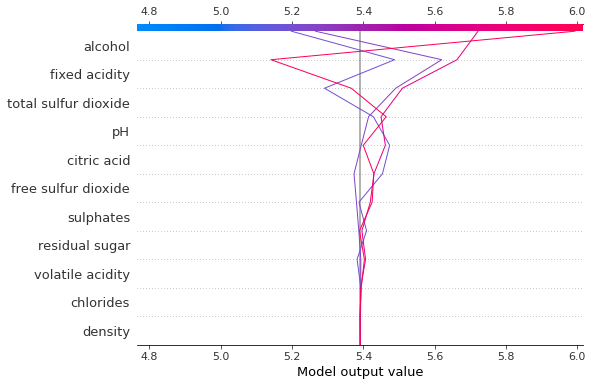

In [151]:
shap.decision_plot(shap_explainer.expected_value,
                   shap_values[0][:4], # 4개만 볼게요~ (더 볼려면 index 를 늘려)
                   X_train) # 여기에 들어간 X_train 은 그냥 feature value 를 뽑아내기 위한녀석에 불과하다.. ㅜㅜ

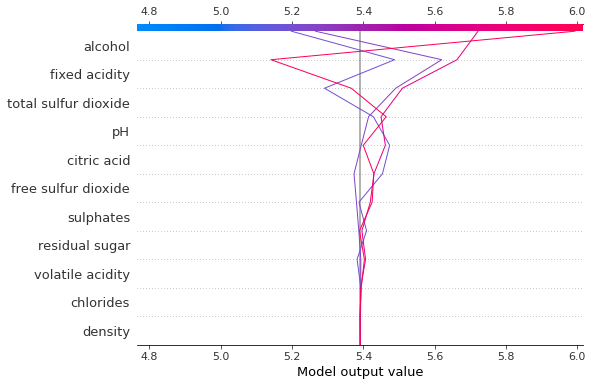

In [152]:
shap.decision_plot(shap_explainer.expected_value,
                   shap_values[0][:4], # 4개만 볼게요~ (더 볼려면 index 를 늘려)
                   X_train) # 여기에 들어간 X_train 은 그냥 feature value 를 뽑아내기 위한녀석에 불과하다.. ㅜㅜ

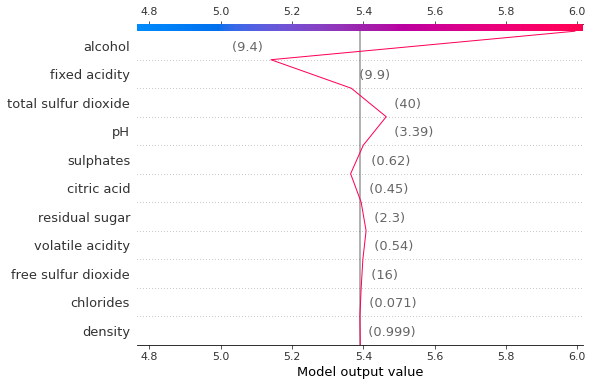

In [153]:
shap.decision_plot(shap_explainer.expected_value,
                   shap_values[0][3], # 1개만 볼게요 # 그러면 각 상태에서 어떤 선택을 해서 값이 나왔는지를 알게된다.
                   X_train,
                  feature_display_range=slice(None, -31, -1)) # 31개까지 보여달란거
# slice(None, None, -1) 를 하면 최대한 다 보여달라는 것이다. 이럴 경우 겁나게 커지는건 인지상정!

## 개별관측

In [154]:
# 관측의 단계는 fitting 이 끝난 후, test 데이터에 시행하는게 바람직 할 것이다! (그래야 모델의 완전한 효과를 볼 수 있을것이므로)

In [155]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model2.predict(X_output),2)
random_picks = np.arange(1,330,50)
Sample = np.array(X_output.iloc[random_picks])
Sample

array([[ 8.1       ,  0.82      ,  0.        ,  4.1       ,  0.095     ,
         5.        , 14.        ,  0.99854   ,  3.36      ,  0.53      ,
         9.6       ,  5.        ],
       [ 5.2       ,  0.32      ,  0.25      ,  1.8       ,  0.103     ,
        13.        , 50.        ,  0.9957    ,  3.38      ,  0.55      ,
         9.2       ,  4.63999987],
       [ 7.1       ,  0.27      ,  0.6       ,  2.1       ,  0.074     ,
        17.        , 25.        ,  0.99814   ,  3.38      ,  0.72      ,
        10.6       ,  5.5999999 ],
       [ 8.2       ,  0.28      ,  0.6       ,  3.        ,  0.104     ,
        10.        , 22.        ,  0.99828   ,  3.39      ,  0.68      ,
        10.6       ,  5.71999979],
       [ 6.8       ,  0.49      ,  0.22      ,  2.3       ,  0.071     ,
        13.        , 24.        ,  0.99438   ,  3.41      ,  0.83      ,
        11.3       ,  5.75      ],
       [ 6.6       ,  0.7       ,  0.08      ,  2.6       ,  0.106     ,
        14.        , 2

In [156]:
shap.initjs()

In [157]:
Sample=np.array(X_train.iloc[:1000,])

In [158]:
shap_explainer = shap.DeepExplainer(model2,Sample)
shap_values = shap_explainer.shap_values(Sample) # 지금은 Sample 에 대해서 해석하고싶어~

### force_plot 시각화

In [159]:
Sample[0]

array([ 9.9   ,  0.54  ,  0.45  ,  2.3   ,  0.071 , 16.    , 40.    ,
        0.9991,  3.39  ,  0.62  ,  9.4   ])

In [160]:
shap.force_plot(shap_explainer.expected_value[0].numpy(),  # expected_value 는 explainer (여기선 tree model) 이 fitting 할 때의 train set 에서 예측한 target 의 평균입니다.
                shap_values[0][0],
               X_train.iloc[0,]) # shap_value 랑 크기를 맞춰줘야 되서 ;;;  겁나 불편하긴 하네요잉

* Output value: is the prediction for that observation
* Base value: The [original paper](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) explains that the base value E(y_hat) is "the value that would be predicted if we did not know any features for the current output." In other words, it is the mean prediction, or mean(yhat). So the mean prediction of Y_test is 5.62.
* Features: The above explanation shows features that contributes to push the final prediction away from the base value.
* Red/blue: Those features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue. 
* Alcohol: has positive impact on the quality rating. The alcohol of this wine is 11.8 which is higher than the average value 10.41. So it pushes the prediction to the right.
* pH: has a negative impact on the quality rating. A lower than the average pH (=3.26 <3.30) drives the prediction to the right.
* Sulphates: is positively related to the quality rating. A lower than the average Sulphates (= 0.64 < 0.65) pushes the prediction to the left.

## 총 관측

In [161]:
shap.force_plot(shap_explainer.expected_value[0].numpy(),  # expected_value 는 explainer (여기선 tree model) 이 fitting 할 때의 train set 에서 예측한 target 의 평균입니다.
                shap_values[0],
               X_train.iloc[0:1000,]) # 이떄두 맞춰줘야되서요..

# 부록 : shap 는 classification 도 잘해요~

In [73]:
# Suppose the target is a binary variable
df['quality_bin'] = np.where(df['quality'].astype(int)>6,1,0)

[0.06068552 0.09181401 0.0426238  0.04684194 0.0637269  0.03552689
 0.08485588 0.03511305 0.04465817 0.20089978 0.29325405]


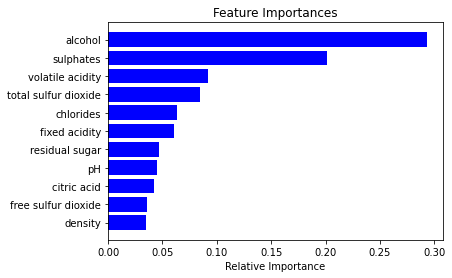

In [74]:
Y = df['quality_bin']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  
print(model.feature_importances_)

importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [35]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


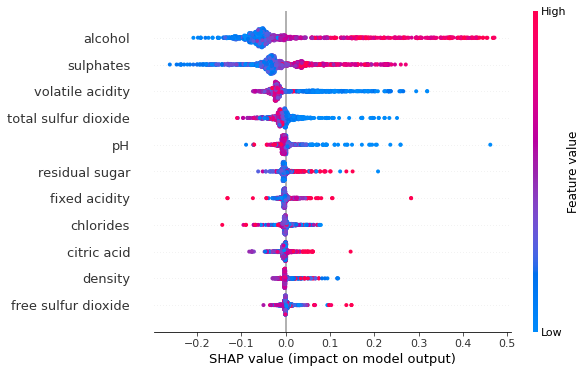

In [36]:
shap.summary_plot(shap_values, X_train)